In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
!pip install --upgrade tensorflow
import base64
import imageio
import io
import matplotlib
import matplotlib.pyplot as plt
import os
import shutil
import tempfile
import tensorflow as tf
import zipfile
import IPython

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import policy_saver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())

2023-06-16 04:35:40.389635: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 04:35:41.287903: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-06-16 04:35:41.288007: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/

In [2]:
!pip install tensorflow 

In [3]:
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
import xvfbwrapper
xvfbwrapper.Xvfb(1400, 900, 24).start()

In [5]:
# Defining my Hyperparameters 
env_name = "MsPacman-v4"

collect_steps_per_iteration = 100
replay_buffer_capacity = 100000

fc_layer_params = (100,)

batch_size = 64
learning_rate = 2.5e-4
log_interval = 1000

num_eval_episodes = 10
eval_interval = 1000

In [6]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [7]:
# Agent 
#@title
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

global_step = tf.compat.v1.train.get_or_create_global_step()

from tf_agents.agents.dqn.dqn_agent import DqnAgent
# see TF-agents issue #113
optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0,   
epsilon=0.00001, centered=True)
train_step = tf.Variable(0)
update_period = 4 # run a training step every 4 collect steps
#optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=2.5e-4, decay=0.95,
# momentum=0.0,epsilon=0.00001, centered=True)
epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial ?
    decay_steps=250000 // update_period, # <=> 1,000,000 ALE frames
    end_learning_rate=0.01) # final ?
agent = DqnAgent(train_env.time_step_spec(),
                train_env.action_spec(),
                q_network=q_net,
                optimizer=optimizer,
                target_update_period=2000, # <=> 32,000 ALE frames
                td_errors_loss_fn=tf.keras.losses.Huber(reduction="none"),
                gamma=0.99, # discount factor
                train_step_counter=global_step,
                epsilon_greedy=lambda: epsilon_fn(train_step))
agent.initialize()

2023-06-16 04:35:54.353904: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 04:35:54.452116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 04:35:54.453916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 04:35:54.507451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild

In [8]:
#Data Collection
#@title
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration)

# Initial data collection
collect_driver.run()

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

2023-06-16 04:36:46.922654: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 10080000000 exceeds 10% of free system memory.


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [9]:
# Train the agent 
#@title
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

def train_one_iteration():
    policy_state = agent.collect_policy.get_initial_state(eval_env.batch_size)

  # Collect a few steps using collect_policy and save to the replay buffer.
    collect_driver.run()


  # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience)

    iteration = agent.train_step_counter.numpy()
    print ('iteration: {0} loss: {1}'.format(iteration, train_loss.loss))

In [10]:
import os
import PIL

def run_episodes_and_create_video(policy, eval_tf_env, eval_py_env):
    num_episodes = 3
    frames = []
    for _ in range(num_episodes):
        time_step = eval_tf_env.reset()
        frames.append(eval_py_env.render())
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = eval_tf_env.step(action_step.action)
            frames.append(eval_py_env.render())
    # Save frames as GIF file
    image_path = os.path.join("images", "rl", "MsPacman.gif")
    frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
    frame_images[0].save(image_path, format='GIF',
                          append_images=frame_images[1:],
                          save_all=True,
                          duration=30,
                          loop=0)
    
    # Display the GIF file
    IPython.display.display(IPython.display.Image(filename=image_path))

In [12]:
checkpoint_dir = os.path.join('Checkpoint', 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)

2023-06-16 04:39:53.444414: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 10080000000 exceeds 10% of free system memory.


In [27]:
# Restore Checkpointer
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [29]:
#upload_and_unzip_file_to('new_checkpointer')
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

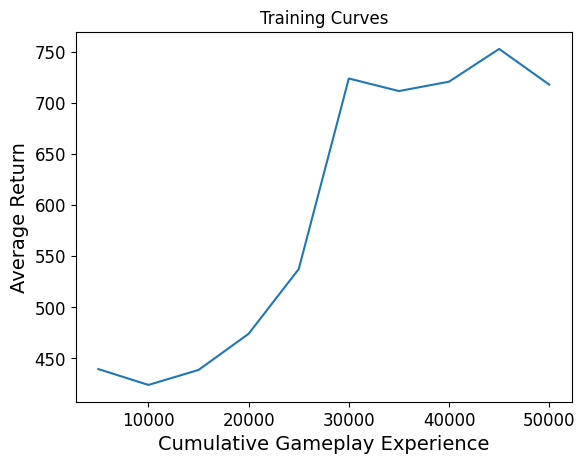

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Define the cumulative amounts of gameplay experience
cumulative_experience = [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000]

# Define the average return values for each cumulative amount of gameplay experience
average_returns = [439.6, 424.1, 438.73, 474.1, 537.36, 723.7, 711.42, 720.6, 752.62, 717.7]

# Plot the training curves
plt.plot(cumulative_experience, average_returns)
plt.xlabel('Cumulative Gameplay Experience')
plt.ylabel('Average Return')
plt.title('Training Curves')
plt.show()


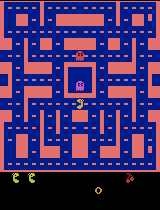

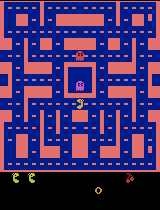

In [ ]:
# Assuming you have already defined the necessary variables and agents

# Load the checkpoints associated with different cumulative amounts of gameplay experience
checkpoints = ['Game/checkpointer/checkpoint/ckpt-1.data-00000-of-00001', 'Game/checkpointer/checkpoint/ckpt-25.data-00000-of-00001','Game/checkpointer/checkpoint/ckpt-99.data-00000-of-00001']# 'checkpoint_20000', 'checkpoint_50000']

# Evaluate the checkpoints and generate videos
for checkpoint in checkpoints:
    # Restore the agent from the checkpoint
    train_checkpointer.initialize_or_restore(checkpoint)

    # Get the policy from the agent
    policy = agent.policy

    # Create the video
    run_episodes_and_create_video(policy, eval_env, eval_py_env)
